### Attention Maps for the TicTacToe Model

In [1]:
import torch
import torch.nn as nn

from utils.files import load_model
from environments.tictactoe_env import TicTacToeEnv

In [2]:
env = TicTacToeEnv()
ppo_obj = load_model(env, 'best_model.zip')
ac_policy = ppo_obj.policy
ac_policy.eval()
features_extractor = ac_policy.features_extractor.extractor

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
> Loading Extractor Heads on device: cpu


#### Prepare Visualization

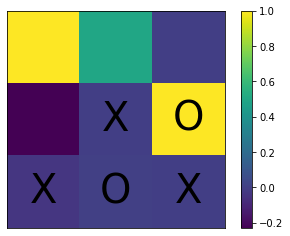

In [3]:
import matplotlib.pyplot as plt

def plot_board(board_color_vals, env=None):
    plt.imshow(board_color_vals, cmap='viridis', interpolation='nearest')
    if env is not None:
        # plot an X or O on the board
        for i in range(3):
            for j in range(3):
                if env.board[i*3 + j].symbol == 'X':
                    plt.text(j, i, 'X', color='black', fontsize=40, ha='center', va='center')
                elif env.board[i*3 + j].symbol == 'O':
                    plt.text(j, i, 'O', color='black', fontsize=40, ha='center', va='center')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()

test_board = torch.tensor([[1, 0.5, 0], [-0.23, 0, 1], [-0.034, 0.004, 0]])
test_env = TicTacToeEnv()
test_env.reset()
test_env.step(8)
test_env.step(7)
test_env.step(6)
test_env.step(5)
test_env.step(4)

plot_board(test_board, test_env)

In [4]:
# get the transformer layers
transformer_layer_module_list = features_extractor.layers
print(transformer_layer_module_list)
    

ModuleList(
  (0-2): 3 x MyTransformerEncoderLayer(
    (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (ff_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (self_attention): MultiHeadAttentionLayer(
      (fc_q): Linear(in_features=64, out_features=64, bias=True)
      (fc_k): Linear(in_features=64, out_features=64, bias=True)
      (fc_v): Linear(in_features=64, out_features=64, bias=True)
      (fc_o): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (rotary_pos_emb): RotaryPositionalEmbedding()
    )
    (positionwise_feedforward): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
)


In [5]:
# get to the attention layer of a given transformer layer
layer_num = 0

attention_layer = transformer_layer_module_list[layer_num].self_attention
obs = test_env.observation[:18].unsqueeze(0).view(-1, 9, 2)
print(obs)

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]]])


#### Base learned embedding into full feature space - Mean value per token

In [6]:
input_embed = features_extractor.embedding(obs).detach()
print(input_embed.shape)

torch.Size([1, 9, 64])


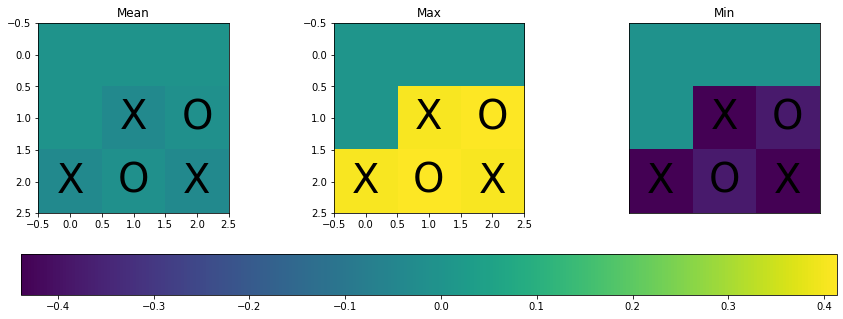

In [7]:
# plot mean, max, min of the input embeddings side by side
def plot_embed_stats(embed, env=None):
    embed = embed.reshape(1, 3, 3, -1)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    min_val = embed.min()
    max_val = embed.max()
    cb = axs[0].imshow(embed.mean(dim=3).squeeze().detach().numpy(), cmap='viridis', interpolation='nearest', vmin=min_val, vmax=max_val)
    axs[0].set_title('Mean')
    axs[1].imshow(embed.max(dim=3).values.squeeze().detach().numpy(), cmap='viridis', interpolation='nearest', vmin=min_val, vmax=max_val)
    axs[1].set_title('Max')
    axs[2].imshow(embed.min(dim=3).values.squeeze().detach().numpy(), cmap='viridis', interpolation='nearest', vmin=min_val, vmax=max_val)
    axs[2].set_title('Min')

    if env is not None:
        # plot an X or O on the board
        for i in range(3):
            for j in range(3):
                if env.board[i*3 + j].symbol == 'X':
                    axs[0].text(j, i, 'X', color='black', fontsize=40, ha='center', va='center')
                    axs[1].text(j, i, 'X', color='black', fontsize=40, ha='center', va='center')
                    axs[2].text(j, i, 'X', color='black', fontsize=40, ha='center', va='center')
                elif env.board[i*3 + j].symbol == 'O':
                    axs[0].text(j, i, 'O', color='black', fontsize=40, ha='center', va='center')
                    axs[1].text(j, i, 'O', color='black', fontsize=40, ha='center', va='center')
                    axs[2].text(j, i, 'O', color='black', fontsize=40, ha='center', va='center')
    
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(cb, ax=axs, orientation='horizontal')
    plt.show()

plot_embed_stats(input_embed, test_env)

Attention Layer

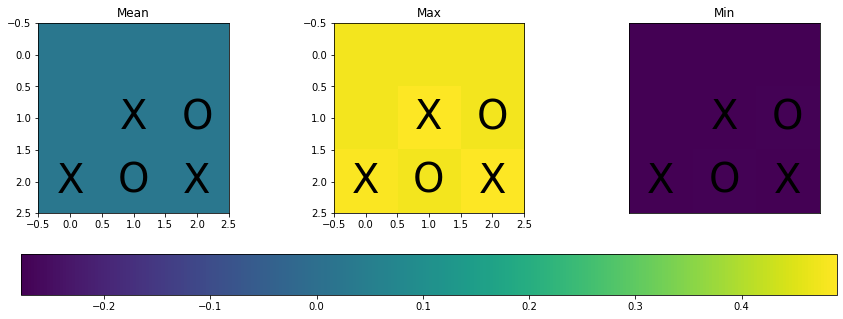

In [8]:
attention_layer_output = attention_layer(input_embed, input_embed, input_embed).detach()
plot_embed_stats(attention_layer_output, test_env)

First Weights applied for each input

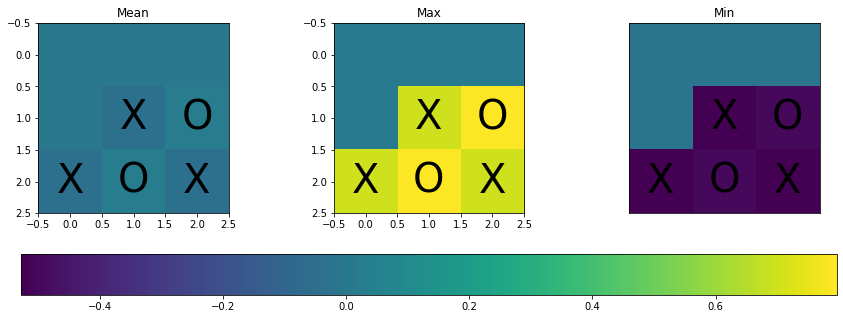

In [9]:
query = attention_layer.fc_q(input_embed)
plot_embed_stats(query, test_env)

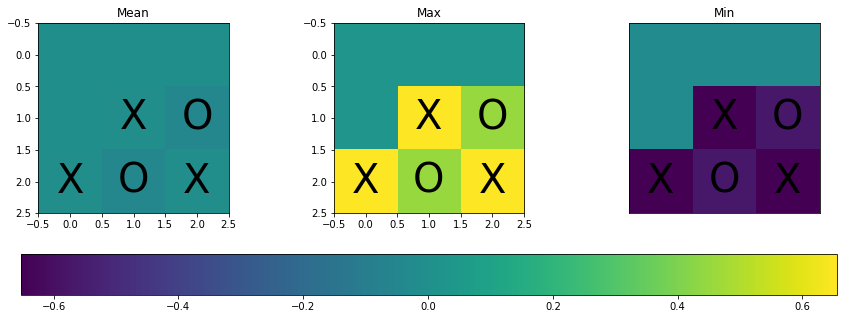

In [10]:
key = attention_layer.fc_k(input_embed)
plot_embed_stats(key, test_env)

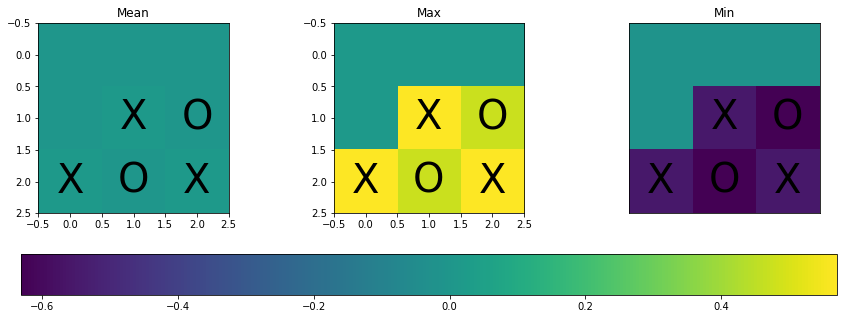

In [11]:
value = attention_layer.fc_v(input_embed)
plot_embed_stats(value, test_env)

Rotary Positional Embedding

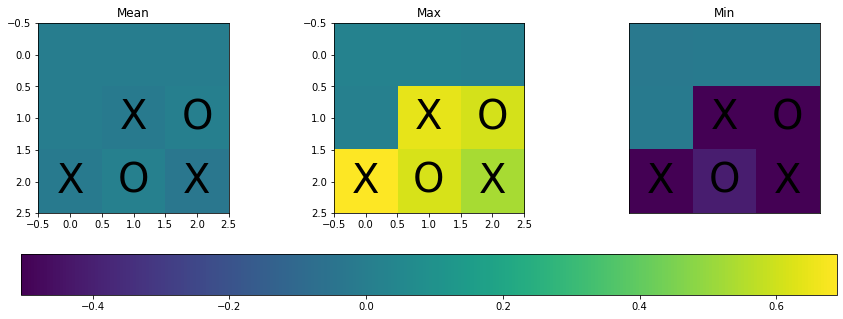

In [12]:
pos_embed = attention_layer.rotary_pos_emb(query)

query = attention_layer.apply_rotary_pos_emb(query, pos_embed)
key = attention_layer.apply_rotary_pos_emb(key, pos_embed)
value = attention_layer.apply_rotary_pos_emb(value, pos_embed)

plot_embed_stats(query, test_env)

### Getting the Activations per Head

In [43]:
# choose the layer to visualize
transformer_layer_index = 2

x = input_embed
for i in range(transformer_layer_index):
    x = features_extractor.layers[i](x, None)

# now continue with the next transformer layer manually
attention_layer = features_extractor.layers[transformer_layer_index].self_attention
query = attention_layer.fc_q(x)
key = attention_layer.fc_k(x)
value = attention_layer.fc_v(x)

pos_embed = attention_layer.rotary_pos_emb(query)
query = attention_layer.apply_rotary_pos_emb(query, pos_embed)
key = attention_layer.apply_rotary_pos_emb(key, pos_embed)
value = attention_layer.apply_rotary_pos_emb(value, pos_embed)

r_q1 = query.view(1, -1, 8, 8).permute(0, 2, 1, 3)
r_k1 = key.view(1, -1, 8, 8).permute(0, 2, 3, 1)
attn = torch.matmul(r_q1, r_k1) / 8**0.5
attn = torch.softmax(attn, dim=-1)
print(attn.shape)

torch.Size([1, 8, 9, 9])


In [44]:
def plot_value_vectors(attn_head, head_index, env=None):
    # Plot the attention values found in attn_head
    plt.imshow(attn_head.squeeze().detach().numpy(), cmap='viridis', interpolation='nearest')
    plt.colorbar()

    if env is not None:
        # plot an X or O vertically next to each row
        for i in range(3):
            for j in range(3):
                if env.board[i*3 + j].symbol == 'X':
                    plt.text(8, i*3+j, 'X', color='black', fontsize=25, ha='center', va='center')
                elif env.board[i*3 + j].symbol == 'O':
                    plt.text(8, i*3+j, 'O', color='black', fontsize=25, ha='center', va='center')

    plt.xticks([])
    plt.yticks([])
    plt.title(f'Attention head {head_index}')
    
    plt.show()

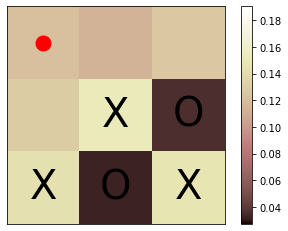

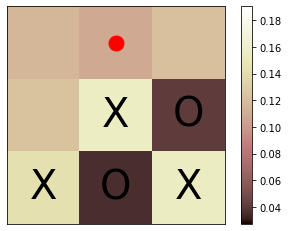

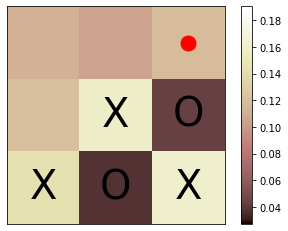

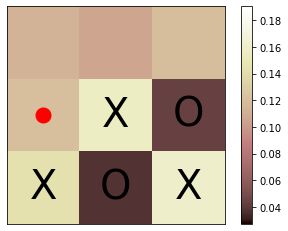

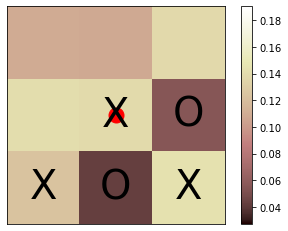

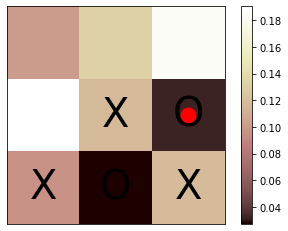

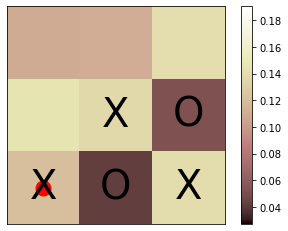

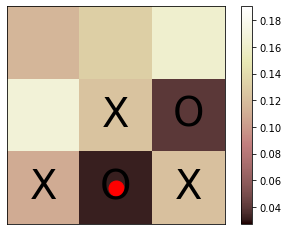

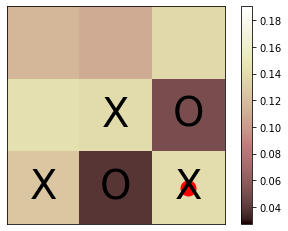

In [45]:
def plot_attn_head(attn_head, querying_token, env=None):
    min_val = attn_head.min()
    max_val = attn_head.max()
    plt.imshow(attn_head[querying_token].reshape(3,3).detach().numpy(), cmap='pink', vmin=min_val, vmax=max_val)
    plt.colorbar()
    
    # mark querying square with a red outline
    querying_square = torch.tensor([querying_token // 3, querying_token % 3])
    plt.plot(querying_square[1], querying_square[0], 'ro', markersize=15)

    if env is not None:
        # plot an X or O on the board
        for i in range(3):
            for j in range(3):
                if env.board[i*3 + j].symbol == 'X':
                    plt.text(j, i, 'X', color='black', fontsize=40, ha='center', va='center')
                elif env.board[i*3 + j].symbol == 'O':
                    plt.text(j, i, 'O', color='black', fontsize=40, ha='center', va='center')
    plt.xticks([])
    plt.yticks([])
    plt.show()

head = 5
attn_head = attn[0, head]

for i in range(9):
    plot_attn_head(attn_head, i, test_env)

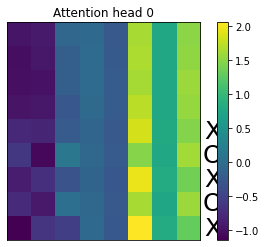

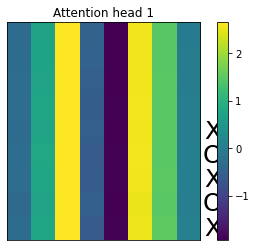

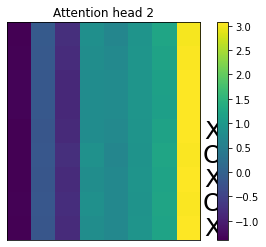

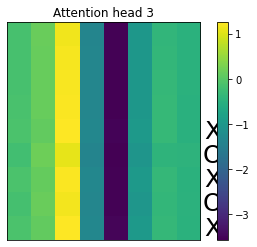

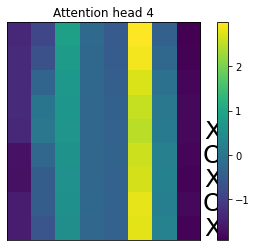

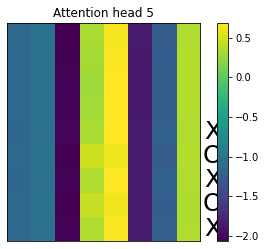

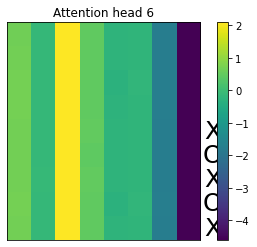

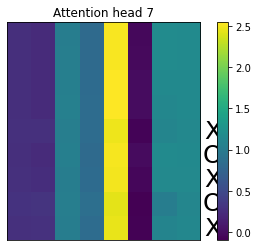

In [46]:
r_v1 = value.view(1, -1, 8, 8).permute(0, 2, 1, 3)
out_tokens = torch.matmul(attn, r_v1) # shape: (1, 8, 9, 8)

for head in range(8):
    plot_value_vectors(out_tokens[0, head], head, test_env)

#### Final Token Vectors returned by layer

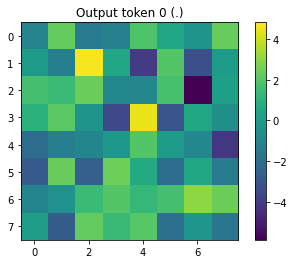

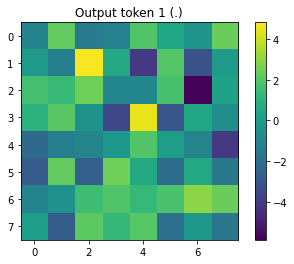

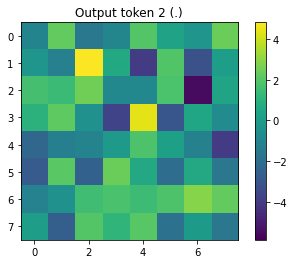

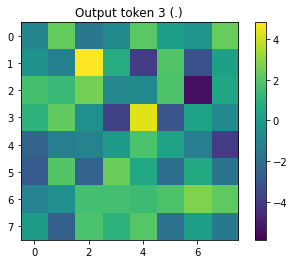

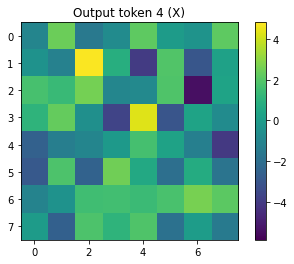

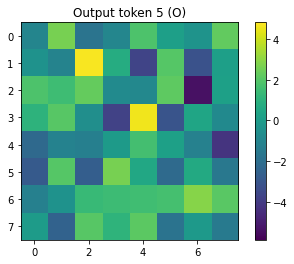

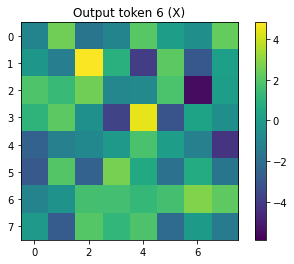

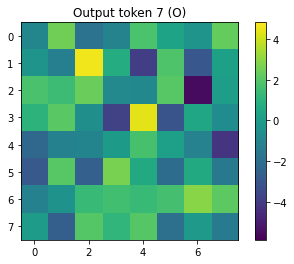

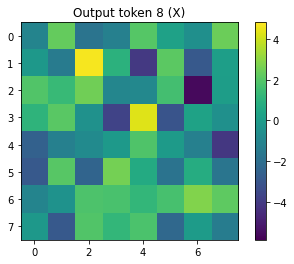

In [47]:
out_vectors = out_tokens.permute(0, 2, 1, 3).reshape(1, 9, -1)
out_vectors = attention_layer.fc_o(out_vectors)

min_val = out_vectors.min()
max_val = out_vectors.max()

for token_index in range(9):
    vals_to_display = out_vectors[0, token_index].reshape(8,8)
    plt.imshow(vals_to_display.detach().numpy(), cmap='viridis', vmin=min_val, vmax=max_val)
    plt.colorbar()
    symbol = test_env.board[token_index].symbol
    plt.title(f'Output token {token_index} ({symbol})')
    plt.show()

In [48]:
out_vectors[0, 0].reshape(8, 8) - out_vectors[0, 5].reshape(8, 8)

tensor([[-0.0906, -0.3372,  0.3278, -0.2419,  0.0325,  0.2810,  0.0376,  0.1109],
        [ 0.3440, -0.1924, -0.0391, -0.2266, -0.3455, -0.0603, -0.0955, -0.2147],
        [-0.1642, -0.0806,  0.0991, -0.1418, -0.0686, -0.4528, -0.4649,  0.0046],
        [-0.0903,  0.0422,  0.2522,  0.2327, -0.0789,  0.1020,  0.1474,  0.2576],
        [ 0.1460, -0.1574,  0.2596, -0.1126,  0.3087, -0.2021,  0.2984,  0.1248],
        [ 0.0786,  0.3549,  0.0926, -0.1924,  0.0851,  0.0753, -0.1189,  0.0874],
        [ 0.1636, -0.0647,  0.0861,  0.5185, -0.2934, -0.0046,  0.1112,  0.3512],
        [ 0.0936, -0.2036,  0.1962,  0.2450, -0.0738, -0.1446, -0.1624, -0.1557]],
       grad_fn=<SubBackward0>)